# Movie Recommendation Engine

We want to perform UV-decomposition to impute missing values in the recommendation matrix. This approach is described in chapter 9 of Yure Leskovic's textbook: http://infolab.stanford.edu/~ullman/mmds/ch9.pdf. 

The algorithm is as follows:
1. Demean movie ratings both within each user and within each movie
2. Perform UV-decomposition on the resulting matrix
3. Multiply the resulting matrices to get the imputed ratings
4. Use cosine similarity of rating columns to find movies which are similar

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import tqdm
import statsmodels.api as sm

# Set the random seed
np.random.seed(0)

# Set up tqdm for pandas
tqdm.tqdm.pandas()

In [2]:
# Read in the ratings data
ratings = pd.read_csv('../raw/ratings.csv')

# Let's enumerate the users so we can use them as indices
users = ratings['userId'].unique()
users = pd.DataFrame(users, columns=['userId'])
users['user_index'] = users.index

# Let's enumerate the movies so we can use them as indices
# Collapse and count the number of ratings per movie
movies = ratings.groupby('movieId').size()
movies = pd.DataFrame(movies, columns=['review_count'])
movies['movieId'] = movies.index
movies = movies.reset_index(drop=True)
movies = movies.sort_values('movieId')
movies = movies.reset_index(drop=True)
movies['movie_index'] = movies.index
movies = movies[['movie_index', 'movieId', 'review_count']]
movies = movies.sort_values('movie_index')
movies = movies.reset_index(drop=True)


# Merge the ratings with the enumerated users and movies
ratings = pd.merge(ratings, users, on='userId')
ratings = pd.merge(ratings, movies, on='movieId')

First, let's standardize the movie ratings

In [3]:
# Demean the ratings by user
user_means = ratings.groupby('user_index')['rating'].mean()
user_sd = ratings.groupby('user_index')['rating'].std()
ratings = ratings.merge(user_means, on='user_index', suffixes=('', '_mean'))
ratings = ratings.merge(user_sd, on='user_index', suffixes=('', '_sd'))
ratings['rating'] = ratings['rating'] - ratings['rating_mean']
ratings['rating'] = ratings['rating'] / ratings['rating_sd']
ratings = ratings.drop(columns=['rating_mean', 'rating_sd'])

# Demean the ratings by movie
movie_means = ratings.groupby('movie_index')['rating'].mean()
movie_sd = ratings.groupby('movie_index')['rating'].std()
ratings = ratings.merge(movie_means, on='movie_index', suffixes=('', '_mean'))
ratings = ratings.merge(movie_sd, on='movie_index', suffixes=('', '_sd'))
ratings['rating'] = ratings['rating'] - ratings['rating_mean']
ratings['rating'] = ratings['rating'] / ratings['rating_sd']
ratings = ratings.drop(columns=['rating_mean', 'rating_sd'])

# If ratings are missing, drop them
# This occurs due to users who only view one movie
# and so have no standard deviation
ratings = ratings.dropna(subset=['rating'])

# Split into training and test sets
# Note: really I should probably do some cluster randomizing by either user or movie???
train = ratings.sample(frac = 0.95)
test = ratings.drop(train.index)

Next, let's convert the long data into a matrix

In [4]:
# Convert the long data into a matrix
# Note we need to use coo_matrix since it's best for iterating over the data and populating
# the predictions matrix
ratings_matrix = sparse.coo_matrix((train['rating'], (train['user_index'], train['movie_index'])))

With our matrix in hand, we can try to perform UV-decomposition

In [5]:
UV_DIM = 10
TOL = 1e-4

# Initialize U and V
U = np.random.rand(ratings_matrix.shape[0], UV_DIM)
V = np.random.rand(ratings_matrix.shape[1], UV_DIM)

# Train the model
error = 1e100
improvement = np.inf
counter = 0
while improvement > TOL:

    old_error = error

    # Note that the actual contraction is *much* faster than the error checking, so let's run this
    # a bunch of times before checking the error
    for i in range(10):
        # Update U
        U = ratings_matrix @ V @ np.linalg.inv(V.T @ V)

        # Update V
        V = ratings_matrix.T @ U @ np.linalg.inv(U.T @ U)

    # Implement matrix multiplication as a map
    matrix_generator = [U[i] @ V[j] for i, j in zip(ratings_matrix.row, ratings_matrix.col)]
    predictions = sparse.coo_matrix((matrix_generator, (ratings_matrix.row, ratings_matrix.col)), shape=ratings_matrix.shape)

    # Compute the error for each element of the matrix, then compute SSE
    error_matrix = ratings_matrix - predictions
    error_vec = error_matrix.data
    error = np.linalg.norm(error_vec)

    improvement = old_error - error

    print(improvement)


1e+100
0.8350918846308559
0.11725937839401013
0.014574732716027938
0.0014550221521858475
-2.2648217964160722e-05


Let's compare the true results against the imputed results out-of-sample

In [6]:
# Construct a ground-truth matrix for the test set
test_matrix = sparse.coo_matrix((test['rating'], (test['user_index'], test['movie_index'])))

# Compute the predictions for the test set
test_predictions = sparse.lil_matrix((test_matrix.shape[0], test_matrix.shape[1]))
for i, j, v in tqdm.tqdm(zip(test_matrix.row, test_matrix.col, test_matrix.data), total=len(test_matrix.data)):
    test_predictions[i, j] = U[i] @ V[j]

true_ratings = test_matrix.data
predicted_ratings = np.array([U[i] @ V[j] for i, j in zip(test_matrix.row, test_matrix.col)])


100%|██████████| 1248691/1248691 [00:03<00:00, 386868.66it/s]


In [7]:
# Create a data frame of the true and predicted ranking with their indices
predictions_df = pd.DataFrame({
    'true': true_ratings, 
    'predicted': predicted_ratings,
    'user_index': test_matrix.row,
    'movie_index': test_matrix.col
})

# For each movie, count how many reviews there are in the training sample
movie_counts = train.groupby('movie_index').size()
movie_counts = pd.DataFrame(movie_counts, columns=['count'])
movie_counts['rank'] = movie_counts['count'].rank(ascending=False)

# Merge the counts with the movie counts
predictions_df_w_counts = predictions_df.merge(movie_counts, left_on='movie_index', right_index=True, suffixes=('', '_count'))

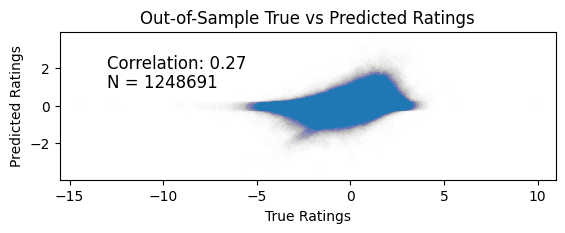

In [8]:
# Scatter the true ratings against the predicted ratings with some transparency
plt.scatter(predictions_df_w_counts['true'], predictions_df_w_counts['predicted'], alpha=0.002)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Out-of-Sample True vs Predicted Ratings')

# Set axis ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Add correlation to the plot
correlation = np.corrcoef(predictions_df['true'], predictions_df['predicted'])[0, 1]

plt.text(-13, 2, f'Correlation: {correlation:.2f}', fontsize=12)
plt.text(-13, 1, f'N = {len(predictions_df)}', fontsize=12)

plt.show()

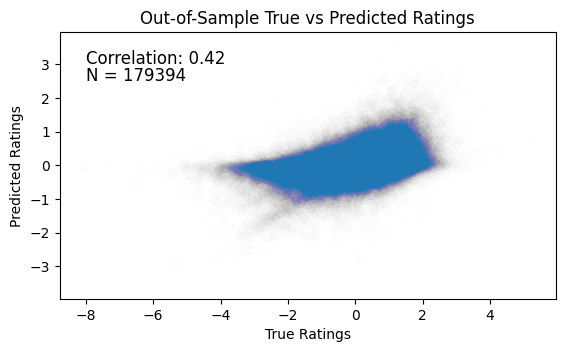

In [9]:
good_data_subset = predictions_df_w_counts[predictions_df_w_counts['count'] > 30000]

# Scatter the true ratings against the predicted ratings with some transparency
plt.scatter(
    good_data_subset['true'],
    good_data_subset['predicted'],
    alpha=0.002,
)

plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Out-of-Sample True vs Predicted Ratings')

# Set axis ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Add correlation to the plot
correlation = np.corrcoef(good_data_subset['true'], good_data_subset['predicted'])[0, 1]

plt.text(-8, 3, f'Correlation: {correlation:.2f}', fontsize=12)
plt.text(-8, 2.5, f'N = {len(good_data_subset)}', fontsize=12)

# Write file to disk
plt.savefig('../output/uv_decomp_out_of_sample.png')

plt.show()

Let's check how the correlation varies with the threshold

In [10]:
thresholds = [1000 * i for i in range(0, 51)]
coefficients = []
errors = []
correlations = []
counts = []

for threshold in thresholds:
    good_data_subset = predictions_df_w_counts[predictions_df_w_counts['count'] > threshold]

    counts.append(len(good_data_subset['movie_index'].unique()))

    # Fit a linear model
    X = sm.add_constant(good_data_subset['true'])
    y = good_data_subset['predicted']
    model = sm.OLS(y, X).fit()
    coefficients.append(model.params['true'])
    errors.append(model.bse['true'])

    correlations.append(np.corrcoef(good_data_subset['true'], good_data_subset['predicted'])[0, 1])


<Figure size 640x480 with 0 Axes>

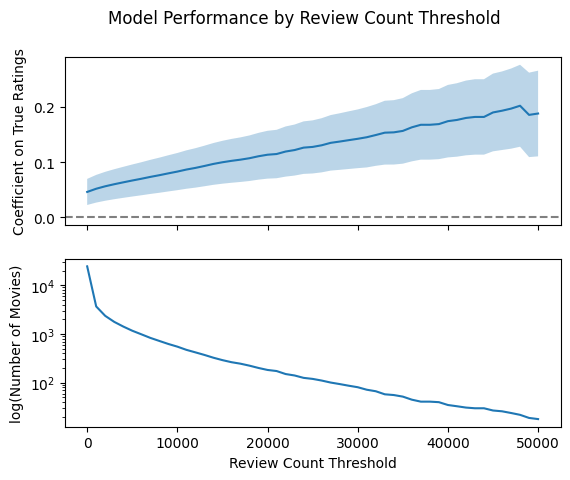

In [12]:
plt.clf()
fig, axs = plt.subplots(2, sharex = True)

fig.suptitle('Model Performance by Review Count Threshold')

# On the first figure, plot the relationship between review count and performance
axs[0].plot(thresholds, coefficients)
axs[0].fill_between(thresholds, np.array(coefficients) - 1.96 * np.sqrt(errors), np.array(coefficients) + 1.96 * np.sqrt(errors), alpha=0.3)
axs[0].set_ylabel('Coefficient on True Ratings')
axs[0].axhline(0, color='grey', linestyle='--')

# On the second figure, plot the number of movies
axs[1].plot(thresholds, counts)
axs[1].set_xlabel('Review Count Threshold')
axs[1].set_ylabel('log(Number of Movies)')
axs[1].set_yscale('log')

plt.savefig('../output/uv_decomp_out_of_sample.png')

plt.show()

Once we have the predicted rankings for each movie, we want to find the pairwise similarities for each movie in our Guru data. 

In [13]:
# Load the tmdb data
# Note we should merge *before* doing the cross-join so we can propogate movie-level results
tmdb = pd.read_parquet('../../tmdb/embeddings/movie_descriptions.parquet')
tmdb = tmdb['tmdb_id'].unique()
tmdb = pd.DataFrame(tmdb, columns=['tmdb_id'])

# Now let's read in the TMDB-MovieLens mapping
tmdb_movielens_xwalk = pd.read_csv('../raw/links.csv').drop(columns=['imdbId'])

# Now we can merge on the movie indices
full_xwalk = movies.merge(
    tmdb_movielens_xwalk, 
    on='movieId', 
    how='left',
    validate='one_to_one'
    )

# If there are any missing TMDB ids, drop them
full_xwalk = full_xwalk.dropna(subset=['tmdbId'])

# For duplicates in TMDB ID, keep only the first
# These seem to be related to some IMDB movies having multiple IDs;
# only true for ~40 movies
full_xwalk = full_xwalk.drop_duplicates(subset='tmdbId')

# Next we can merge the indices onto the tmdb data
tmdb = tmdb.merge(full_xwalk, left_on='tmdb_id', right_on='tmdbId', validate='one_to_one')
tmdb = tmdb.drop(columns=['tmdb_id'])

# Filter only to popular movies
THRESHOLD = 10000
tmdb = tmdb[tmdb['review_count'] > THRESHOLD]

In [14]:
# Finally we can compute the predicted review vectors for each movie
tmdb['reviews'] = tmdb['movie_index'].apply(lambda x: U[x] @ V.T)
tmdb['characteristics'] = tmdb['movie_index'].apply(lambda x: U[x])
tmdb['review_norm'] = tmdb['reviews'].apply(lambda x: np.linalg.norm(x))
tmdb['characteristic_norm'] = tmdb['characteristics'].apply(lambda x: np.linalg.norm(x))

Now that we've projected out reviews for each movie, we want to compute the pairwise similarity between each *pair* of movies using the cosine similarity. 

In [15]:
# Create each possible pair of movies
tmdb_pairs = tmdb.merge(tmdb, how='cross')

Now that we've produced the TMDB pairs, we want to compute the similarity between each pair of movies under our UV-decomposition model. 

In [16]:
def compute_similarity(row):
    # Get the movie vectors
    movie_x_vec = row['reviews_x']
    movie_y_vec = row['reviews_y']

    movie_x_norm = row['review_norm_x']
    movie_y_norm = row['review_norm_y']

    # Compute the cosine similarity
    similarity = np.dot(movie_x_vec, movie_y_vec) / (movie_x_norm * movie_y_norm)
    return similarity

def compute_characteristic_similarity(row):
    # Get the movie vectors
    movie_x_vec = row['characteristics_x']
    movie_y_vec = row['characteristics_y']

    movie_x_norm = row['characteristic_norm_x']
    movie_y_norm = row['characteristic_norm_y']

    # Compute the cosine similarity
    similarity = np.dot(movie_x_vec, movie_y_vec) / (movie_x_norm * movie_y_norm)
    return similarity

# Compute the similarity for each pair
tmdb_pairs['similarity_reviews'] = tmdb_pairs.progress_apply(compute_similarity, axis=1)
tmdb_pairs['similarity_characteristics'] = tmdb_pairs.progress_apply(compute_characteristic_similarity, axis=1)

  0%|          | 0/66564 [00:00<?, ?it/s]

  0%|          | 248/66564 [00:00<03:13, 343.12it/s]C:\Users\gmoor\AppData\Local\Temp\ipykernel_28156\3026424883.py:10: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.dot(movie_x_vec, movie_y_vec) / (movie_x_norm * movie_y_norm)
  0%|          | 0/66564 [00:00<?, ?it/s]C:\Users\gmoor\AppData\Local\Temp\ipykernel_28156\3026424883.py:22: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.dot(movie_x_vec, movie_y_vec) / (movie_x_norm * movie_y_norm)
100%|██████████| 66564/66564 [00:00<00:00, 111521.25it/s]


Scatter user similarities and characteristic similarities

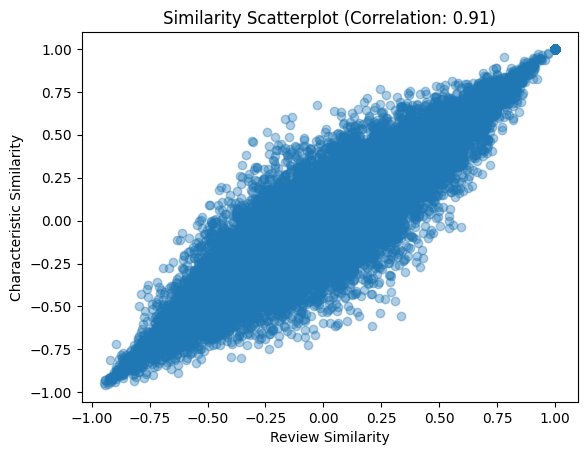

In [17]:
# Scatter the similarities
corr = tmdb_pairs['similarity_reviews'].corr(tmdb_pairs['similarity_characteristics'])
plt.scatter(tmdb_pairs['similarity_reviews'], tmdb_pairs['similarity_characteristics'], alpha=0.2)
plt.xlabel('Review Similarity')
plt.ylabel('Characteristic Similarity')
plt.title(f'Similarity Scatterplot (Correlation: {corr:.2f})')
plt.show()

In [18]:
# Sort by tmdbID_x and then similarity
tmdb_pairs = tmdb_pairs.sort_values(['tmdbId_x', 'similarity_reviews'], ascending=[True, False])

Once we have the similarity measures, we'll save them to a file linked to their TMDB IDs.

In [19]:
# Write the results to disk
tmdb_pairs.to_csv('../output/UV_decomp_similarity.csv', index=False)
#tmdb_pairs_trimmed.to_csv('../output/UV_decomp_similarity.csv', index=False)

Let's now correlate this measure with the text-based similarity measure

In [20]:
# Construct the two similarity frames
text_similarities = pd.read_parquet('../../movie_text_distances/output/movie_text_distances.parquet')
text_similarities['text_similarity'] = 1 - text_similarities['distance']
text_similarities_copy = text_similarities.copy()
text_similarities_copy['temp'] = text_similarities_copy['tmdb_id_1']
text_similarities_copy['tmdb_id_1'] = text_similarities_copy['tmdb_id_2']
text_similarities_copy['tmdb_id_2'] = text_similarities_copy['temp']
text_similarities_copy = text_similarities_copy.drop(columns=['temp'])
text_similarities = pd.concat([text_similarities, text_similarities_copy], axis=0)

collaborative_similarities = tmdb_pairs[['tmdbId_x', 'tmdbId_y', 'similarity_reviews', 'similarity_characteristics']]
collaborative_similarities = collaborative_similarities.rename(columns = {
    'similarity_reviews': 'user_collab_similarity', 
    'similarity_characteristics': 'char_collab_similarity',
    'tmdbId_x': 'tmdb_id_1',
    'tmdbId_y': 'tmdb_id_2'
    })

In [21]:
# Take the inner join of the two frames
combined_similarities = text_similarities.merge(collaborative_similarities, on=['tmdb_id_1', 'tmdb_id_2'], how='inner')

Let's merge on review counts

In [22]:
# Merge on review counts
combined_similarities = combined_similarities.merge(
    tmdb[['tmdbId', 'review_count']],
    left_on='tmdb_id_1',
    right_on='tmdbId',
    how='left'
)
combined_similarities = combined_similarities.rename(columns={'review_count': 'review_count_1'})
combined_similarities = combined_similarities.drop(columns=['tmdbId'])

combined_similarities = combined_similarities.merge(
    tmdb[['tmdbId', 'review_count']],
    left_on='tmdb_id_2',
    right_on='tmdbId',
    how='left'
)
combined_similarities = combined_similarities.rename(columns={'review_count': 'review_count_2'})
combined_similarities = combined_similarities.drop(columns=['tmdbId'])

Plot the correlation between the two similarities.

In [23]:
thresholds = [1000 * i for i in range(10, 51)]
correlations = []
coefficients = []
errors = []
counts = []

sim_type = 'user_collab_similarity'

for threshold in thresholds:
    filtered_df = combined_similarities[(combined_similarities['review_count_1'] > threshold) & (combined_similarities['review_count_2'] > threshold)]
    # Drop NAs
    filtered_df = filtered_df.dropna()
    correlation = filtered_df['text_similarity'].corr(filtered_df[sim_type])
    correlations.append(correlation)

    # Fit a linear model
    X = sm.add_constant(filtered_df['text_similarity'])
    model = sm.OLS(filtered_df[sim_type], X)
    results = model.fit()
    coefficients.append(results.params['text_similarity'])
    errors.append(results.bse['text_similarity'])
    counts.append(len(filtered_df))


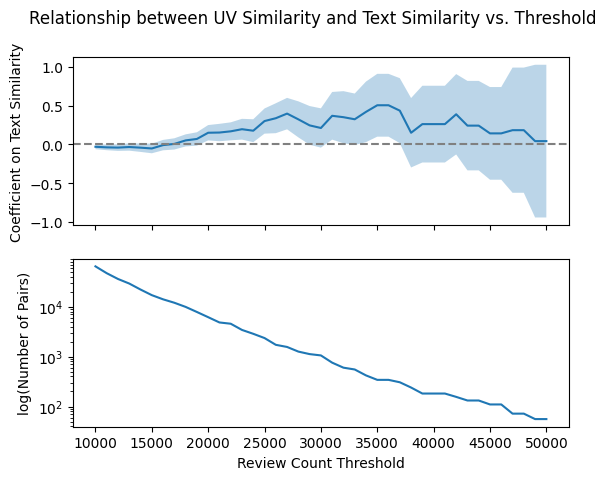

In [26]:
fig, axs = plt.subplots(2, sharex=True)

fig.suptitle('Relationship between UV Similarity and Text Similarity vs. Threshold')

# On the first figure, plot the relationship between review count and performance
axs[0].plot(thresholds, coefficients)
axs[0].fill_between(thresholds, np.array(coefficients) - 1.96 * np.array(errors), np.array(coefficients) + 1.96 * np.array(errors), alpha=0.3)
axs[0].set_ylabel('Coefficient on Text Similarity')
axs[0].axhline(0, color='grey', linestyle='--')

# On the second figure, plot the number of pairs
axs[1].plot(thresholds, counts)
axs[1].set_xlabel('Review Count Threshold')
axs[1].set_ylabel('log(Number of Pairs)')
axs[1].set_yscale('log')

plt.savefig('../output/UV_decomp_coef_vs_review_count.png')

plt.show()